In [29]:
# Import libraries

%pylab inline
import glob
import os
import imp
import math
import re
from matplotlib import image as im
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import ticker
from scipy import ndimage, interpolate
from numpy import fft
from scipy import stats


Populating the interactive namespace from numpy and matplotlib


In [30]:
def load_imagesWFR (path, query):
    """ Load images from camera or MC Simulation
    path: Directory from which to search for files
    query: Regex search string to choose file from previous directory
    """
    files = glob.glob(path + query)
    files.sort()
    retArr = dict()
    ascs = []
    sources = set()
    for i in files:
        listProp = []
        filename = os.path.basename(i)
        listRawProp = re.split("['_a','_s',.]+", filename)
        #print (listRawProp)
        for j in range(len(listRawProp)):
            try:
                number = int(listRawProp[j])
                listProp.append(number)
            except:
                pass
        #print (listProp)
        retArr[float(listProp[0]), float(listProp[1])] = np.genfromtxt(i)
    print("Loaded files: " + str(len(retArr)))
    for key, value in retArr.items() :
        sources.add((float(key[0]), float(key[1])))
    print("Sources: ", sources)
    return retArr, sources

In [31]:
def fft_gauss (in_array, kernel_size):
    """Perform FFR Gauss low-pass filtering
    in_array: input image
    kernel_size: kernel size for smoothing
    """
    
    # FFT filter
    im_fft = fft.rfftn(in_array)
    im_rfft_filtered = ndimage.fourier_gaussian(im_fft, kernel_size, in_array.shape[1])
    im_filtered = fft.irfftn(im_rfft_filtered)
    
    #Power spectrum       
    pwr_spectrum = abs(fft.fftshift(im_fft))**2
    pwr_spectrum_filtered = abs(fft.fftshift(im_rfft_filtered))**2
        
    #Re-normalization
    sum_ratio= in_array.sum()/im_filtered.sum()
    im_filtered = im_filtered*sum_ratio
    
    return im_filtered, pwr_spectrum, pwr_spectrum_filtered

In [32]:
def to_XY(rdArray, dr, dx, Nx, dy, Ny, x0, y0, rMin):
    """Convert linear sensitivity array to 2D image, using input as radius
    rdArray: 1D input array
    dr: step size in rdArray
    dx: step size in X axis in 2D output image
    Nx: number of pixels in X axis in 2D output image
    dy: step size in Y axis in 2D output image
    Ny: number of pixels in Y axis in 2D output image
    x0: X coordinate of the source
    y0: Y coordinate of the source
    rMin: Minimum radius to be extrapolated from rdArray. Data below this radius is set to 1 
    """
    Nr = shape(colArray)[0]
    xyArray = np.zeros((Nx,Ny), float)
    for x in range(Nx):
        for y in range(Ny):
            xPos = (x+0.5-Nx/2)*dx
            yPos = (y+0.5-Ny/2)*dy
            rXy2 = (xPos-x0)**2 + (yPos-y0)**2
            if rXy2 < (Nr*dr)**2 and rXy2 > rMin :
                rInterpolated = interpolate.interp1d([row[0] for row in colArray],[row[1] for row in colArray])
                xyArray[x][y] = rInterpolated(math.sqrt(rXy2)) #* (1-1*math.exp(math.sqrt(1/(r_xy2-x0))))
            else:
                xyArray[x][y] = 0
    print(np.shape(xyArray))
    #fig = plt.figure()
    #plt.imshow(xyArray)
    return xyArray

Loaded files: 36
Sources:  {(1.0, 3.0), (-3.0, -1.0), (1.0, -5.0), (-1.0, -3.0), (-1.0, 5.0), (-5.0, 5.0), (-3.0, 3.0), (3.0, -3.0), (5.0, -5.0), (5.0, 1.0), (1.0, -1.0), (-1.0, 1.0), (-5.0, 1.0), (-3.0, -3.0), (-5.0, -5.0), (3.0, 3.0), (5.0, 5.0), (1.0, 5.0), (-5.0, -1.0), (-1.0, -1.0), (1.0, -3.0), (1.0, 1.0), (5.0, -1.0), (-3.0, 1.0), (-5.0, 3.0), (-3.0, 5.0), (-5.0, -3.0), (-1.0, -5.0), (-3.0, -5.0), (3.0, -5.0), (3.0, 5.0), (5.0, -3.0), (5.0, 3.0), (-1.0, 3.0), (3.0, 1.0), (3.0, -1.0)}


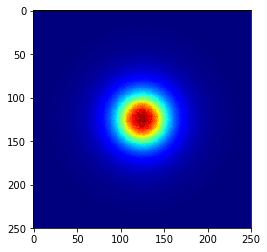

In [33]:
# Sizes - full image
XFsize=500
YFsize=500

# Sizes - individual images
Xsize=250
Ysize=250
dX=0.04
dY=0.04

# Load MC images
path="/home/nicolas/Documentos/Universidad/Simulaciones/WFR Traslation 2/"
images, sources = load_imagesWFR(path, "*_FlR.dat")
sources = sorted(sources)
imshow(images[(1,1)], cmap="jet")


In [40]:
# Generate sensitivity map from theory profile

NpointsInc = 60
MaxDistance = 15
colArray=np.loadtxt("/home/nicolas/Documentos/Universidad/Sources/Fluorescencia semi_inf/teo_sens2_z1.0.dat")
XY_Prof_Sens = to_XY (colArray, MaxDistance/NpointsInc, dX, Xsize, dY, Ysize, 0, 0, 0.02)
np.savetxt("/home/nicolas/Documentos/Universidad/Sources/Fluorescencia semi_inf/teoXY.dat",XY_Prof_Sens)

(250, 250)


In [35]:
# Create background and divide

imagesDiv=dict()
imagesDivFFT=dict()
back = dict()


# Background reference images

backTemp=np.full((Xsize,Ysize),0, dtype=float)

for itemS in sources:
    backTemp += images[itemS]
back = backTemp/len(sources)


# Normalization

for itemS in sources:
    imagesDiv[itemS] = (images[itemS]/back)
    #imagesDivFFT[itemS] = fft_gauss(imagesDiv[itemS], 6)[0]

In [36]:
# Construct weighted average

# Declare and fill arrays
fullImageTemp= np.full((len(sources),XFsize,YFsize),0,dtype=float)
fullImageSens= np.full((len(sources),XFsize,YFsize),0,dtype=float)
fullImageCount= np.full((XFsize,YFsize),0,dtype=float)
fullImageAvgW = np.full((XFsize,YFsize),0, dtype=float)

# Initialize counter
iS = 0

# Combine images into a single array, construct weights for each pixel
for itemS in sources:
           
    corrx = int((itemS[1]+(XFsize-Xsize)*dX/2)/dX)
    corry = int((itemS[0]+(YFsize-Ysize)*dX/2)/dY)
    
    for ix in range (Xsize):
        for iy in range (Ysize):
            fullImageSens[iS,ix+corrx,iy+corry] += XY_Prof_Sens[ix,iy]
            fullImageTemp[iS,ix+corrx,iy+corry] = imagesDiv[itemS][ix,iy]
            fullImageCount[ix+corrx,iy+corry] += 1
    iS += 1
    
# Calculate weighted average
fullImageAvgW = np.average(fullImageTemp, weights=fullImageSens, axis=0)
fullImageAvg = np.sum(fullImageTemp, axis=0)/fullImageCount

(-0.5, 499.5, 499.5, -0.5)

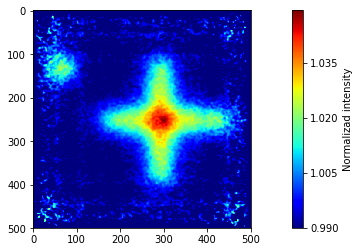

In [37]:
# Plot result and save image

fig = plt.figure()
plt.imshow(fft_gauss(fullImageAvgW,2)[0], vmin=0.99, cmap="jet")
cbar = plt.colorbar()
cbar.set_label("Normalizad intensity")
tick_locator = ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()
plt.axis('image')
#fig.savefig(path + "res_avgW_sens_z1_r0.3.png" )

(-0.5, 499.5, 499.5, -0.5)

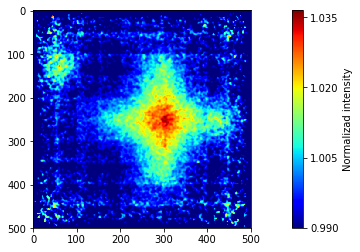

In [38]:
# Plot result and save image

fig = plt.figure()
plt.imshow(fft_gauss(fullImageAvg,2)[0], vmin=0.99, cmap="jet")
cbar = plt.colorbar()
cbar.set_label("Normalizad intensity")
tick_locator = ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()
plt.axis('image')
#fig.savefig(path + "res_avg.png" )